In [1]:
from plurals.agent import Agent
from plurals.deliberation import Chain, Debate, Ensemble
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd
import sys 
from tqdm import tqdm
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *
import lexical_diversity

import numpy as np
from sklearn.metrics import pairwise_distances
from sentence_transformers import SentenceTransformer

# semantic distnace model 
MODEL = SentenceTransformer('all-mpnet-base-v2')

/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. 

# Read in political issues

In [19]:

# Parameters
###################
model = "gpt-4o"
n_words = 100
n_issues = 4
n_per_block = 30
fn = f"../data/raw/{n_words}words_{n_issues}issues_{n_per_block}iters_{model}_pol_responses.csv"
###################

# Read in issues
###################
pol_issues = pd.read_csv("../data/raw/2024-08-08_isidewith_political_issues_popular.csv")
issues = pol_issues.sort_values(by=['initial_order'], ascending=True).head(n_issues)
issues['description_instructions'] = issues['question'] + " " + "Answer in {} words with a rationale.".format(n_words)
issues.to_csv("../data/processed/issue_prompts.csv")
issues_json = issues[['issue', 'description_instructions']].to_json(orient='records')
###################



# Generate responses
###################
data = []
agent_types = {
        'persona_conservative': {"ideology": "conservative"},
        'persona_liberal': {"ideology": "liberal"}, 
        'default_conservative': {"ideology": "conservative"},
        'default_liberal': {"ideology": "liberal"},
}

total_iters = n_issues * n_per_block * len(agent_types)
used_personas = set()
with tqdm(total=total_iters) as pbar:
    counter = 0
    for idx, row in issues.iterrows():
        topic = row['issue']
        prompt = row['description_instructions']
        for iter in range(n_per_block):
            for agent_type in list(agent_types.keys()):
                ideology_query = agent_types[agent_type]['ideology']
                if "persona_" in agent_type:
                    fresh_persona = False
                    while not fresh_persona:
                        agent = Agent(ideology=ideology_query, model=model, kwargs={'seed':counter})
                        if agent.persona not in used_personas:
                            fresh_persona = True             
                            used_personas.add(agent.persona)       
                else:
                    agent = Agent(system_instructions="You are a {}".format(ideology_query), model=model, kwargs={'seed':counter})
                resp = agent.process(prompt)
                data_pt = {
                    "topic": topic,
                    "agent_type": "persona" if "persona_" in agent_type else "default",
                    "ideology": ideology_query,
                    "prompt": prompt,
                    "response": resp, 
                    "iter": iter, 
                    "system_instructions": agent.system_instructions,
                }
                data.append(data_pt)
                counter += 1
                pbar.update(1)

resp_df = pd.DataFrame(data)
resp_df.to_csv(fn)
###################

100%|██████████| 480/480 [11:36<00:00,  1.45s/it]


In [20]:
resp_df = pd.DataFrame(data)
resp_df.to_csv("resp_df.csv")

In [21]:
resp_df = pd.read_csv("resp_df.csv")

In [14]:
!pip install lexical-diversity

  Using cached lexical_diversity-0.1.1-py3-none-any.whl (117 kB)
You should consider upgrading via the '/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/bin/python3 -m pip install --upgrade pip' command.


In [30]:
from lexical_diversity import lex_div as ld
div_data = []


def flatten(xss):
    # https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    return [x for xs in xss for x in xs]

def compute_diversity_metrics(responses, toks, model):
    pw_dist, centroid_dist, max_pw_distance = sbert_diversity(responses, model)
    d =  {
        'lexical_diversity': ld.ttr(toks),
        'pw_dist': pw_dist,
        'mean_centroid_dist': centroid_dist,
        'max_pw_distance': max_pw_distance,
    }
    return d


def sbert_diversity(responses, model):
    embeds = model.encode(responses)
    centroid = np.mean(embeds, axis=0)
    mean_centroid_distance = np.mean(pairwise_distances(embeds, centroid.reshape(1, -1), metric='cosine'))
    pw_distance = pairwise_distances(embeds, metric='cosine')
    mean_pw_distance = np.mean(pw_distance)
    max_pw_distance = np.max(pw_distance)
    return mean_pw_distance, mean_centroid_distance, max_pw_distance

resp_df['ideology'] = resp_df['ideology']
resp_df['toks'] = resp_df['response'].apply(lambda x: x.split())
resp_df['diversity'] = resp_df['toks'].apply(lambda x: ld.ttr(x))
topics = resp_df['topic'].unique()
ideology = resp_df['ideology'].unique()
agent_type = resp_df['agent_type'].unique()

for topic in topics:
    for agent in agent_type:
        for ideo in ideology:
            responses = resp_df[(resp_df['topic'] == topic) & (resp_df['agent_type'] == agent) & (resp_df['ideology'] == ideo)]['response'].to_list()
            toks = resp_df[(resp_df['topic'] == topic) & (resp_df['agent_type'] == agent) & (resp_df['ideology'] == ideo)]['toks'].to_list()
            toks = flatten(toks)




            data_pt = {
                'topic': topic,
                'agent_type': agent,
                'ideology': ideo,
            }
            data_pt.update(compute_diversity_metrics(responses, toks, MODEL))
            div_data.append(data_pt)

div_df = pd.DataFrame(div_data)



In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from lexical_diversity import lex_div as ld
from scipy.stats import bootstrap

div_data = []

def flatten(xss):
    return [x for xs in xss for x in xs]

def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    """Compute the mean and 95% confidence intervals using bootstrapping."""
    res = bootstrap((data,), np.mean, confidence_level=confidence_level, n_resamples=num_bootstrap_samples)
    return res.confidence_interval.low, res.confidence_interval.high

def compute_diversity_metrics(responses, toks, embeds):
    mean_pw_distance, mean_centroid_distance, max_pw_distance = sbert_diversity(embeds)
    lexical_diversity = ld.ttr(toks)
    mltd = ld.mtld(toks)
    return {
        'type_token_ratio': lexical_diversity,
        'mltd': mltd,
        'pw_dist': mean_pw_distance,
        'mean_centroid_dist': mean_centroid_distance,
        'max_pw_distance': max_pw_distance,
    }

def sbert_diversity(embeds):
    centroid = np.mean(embeds, axis=0)
    centroid_distances = pairwise_distances(embeds, centroid.reshape(1, -1), metric='cosine').flatten()
    pw_distances = pairwise_distances(embeds, metric='cosine')
    mean_centroid_distance = np.mean(centroid_distances)
    mean_pw_distance = np.mean(pw_distances)
    max_pw_distance = np.max(pw_distances)

    lower_centroid, upper_centroid = bootstrap_confidence_interval(centroid_distances)
    lower_pw, upper_pw = bootstrap_confidence_interval(pw_distances.flatten())

    return mean_pw_distance, (lower_pw, upper_pw), mean_centroid_distance, (lower_centroid, upper_centroid), max_pw_distance

# Sample data setup and iteration over DataFrame
resp_df['toks'] = resp_df['response'].apply(lambda x: x.split())
resp_df['embedding'] = [x for x in MODEL.encode(resp_df['response'])]
topics = resp_df['topic'].unique()
ideology = resp_df['ideology'].unique()
agent_type = resp_df['agent_type'].unique()

for topic in topics:
    for agent in agent_type:
        for ideo in ideology:
            subset = resp_df[(resp_df['topic'] == topic) & (resp_df['agent_type'] == agent) & (resp_df['ideology'] == ideo)]
            responses = subset['response'].tolist()
            toks = flatten(subset['toks'].tolist())
            embeds = subset['embedding'].tolist()
            metrics = compute_diversity_metrics(responses, toks,embeds)
            div_data.append({
                'topic': topic,
                'agent_type': agent,
                'ideology': ideo,
                **metrics
            })

div_df = pd.DataFrame(div_data)


ValueError: too many values to unpack (expected 3)

In [31]:
cols = div_df.columns.tolist()
bad_cols = ['topic', 'agent_type', 'ideology']
dvs = [col for col in cols if col not in bad_cols]
div_df[dvs].corr()


,lexical_diversity,pw_dist,mean_centroid_dist,max_pw_distance
lexical_diversity,1.000000,0.723287,0.722184,0.637785
pw_dist,0.723287,1.000000,0.999931,0.920001
mean_centroid_dist,0.722184,0.999931,1.000000,0.918513
max_pw_distance,0.637785,0.920001,0.918513,1.000000


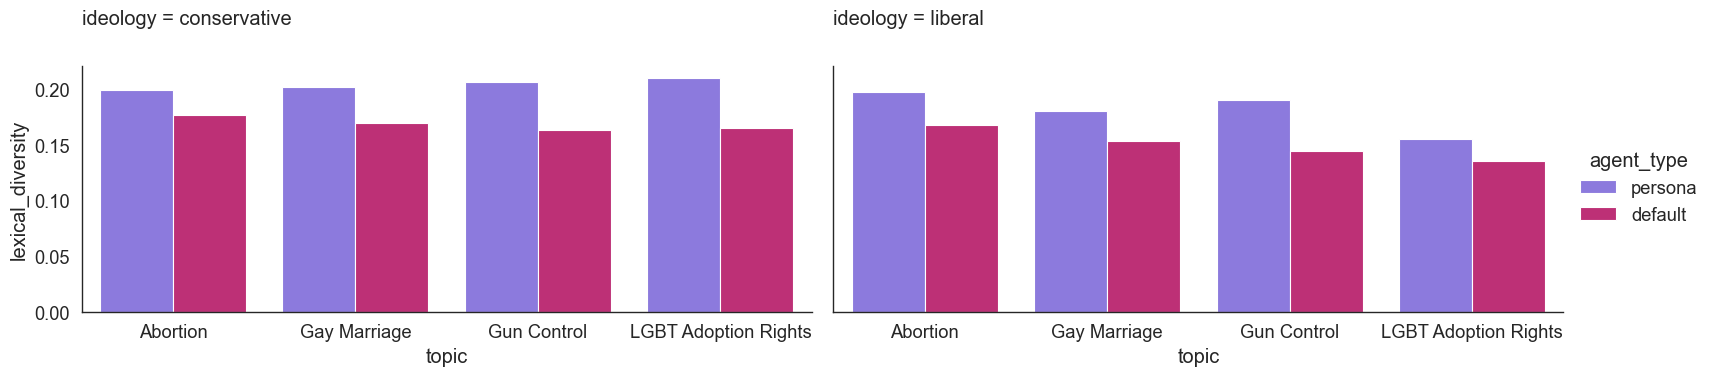

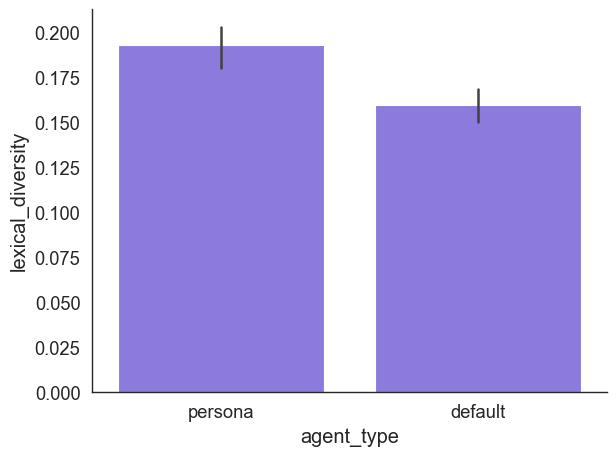

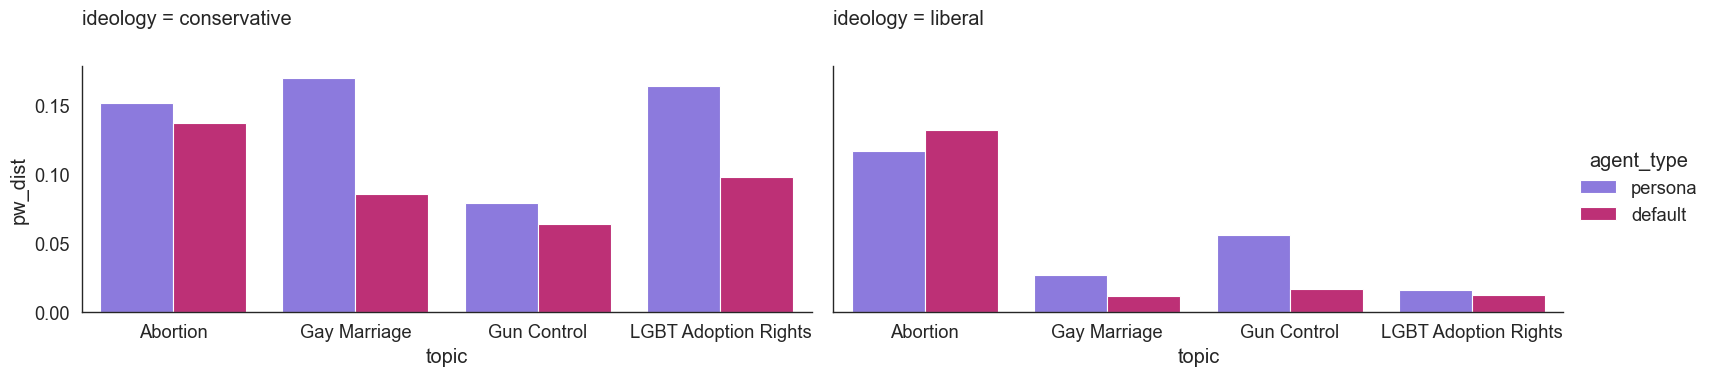

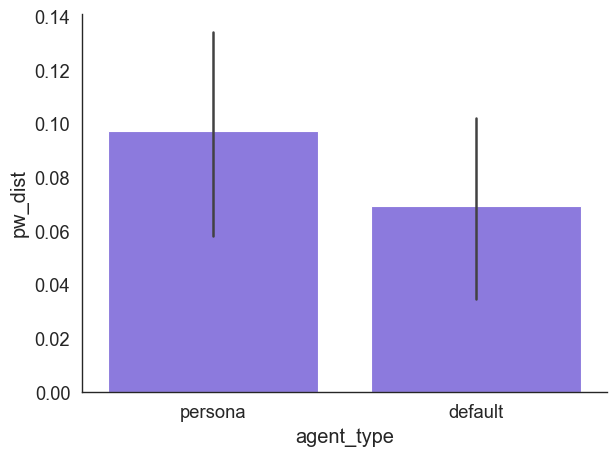

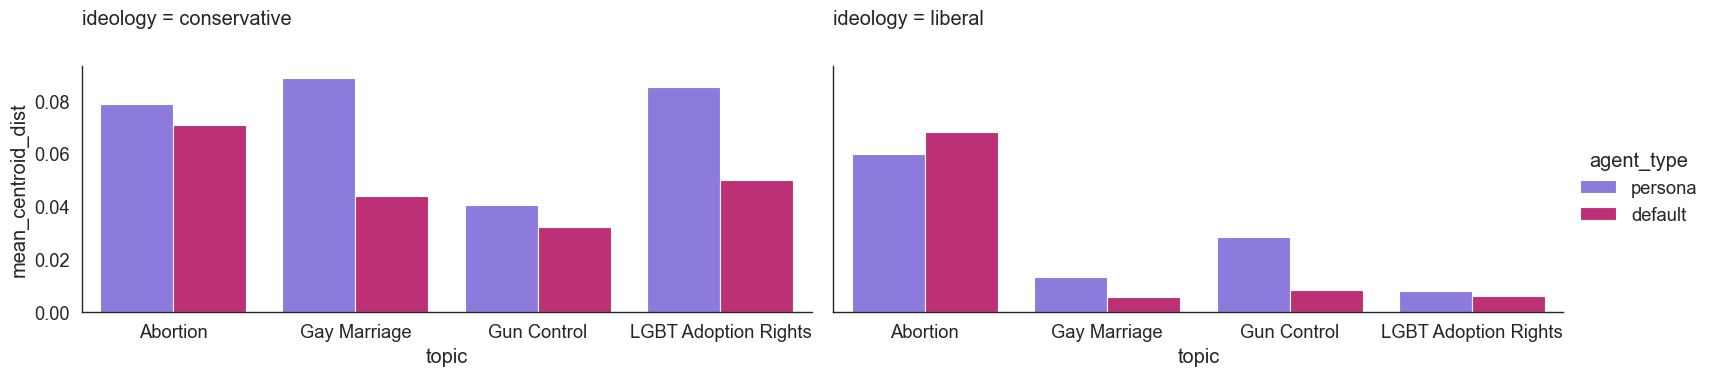

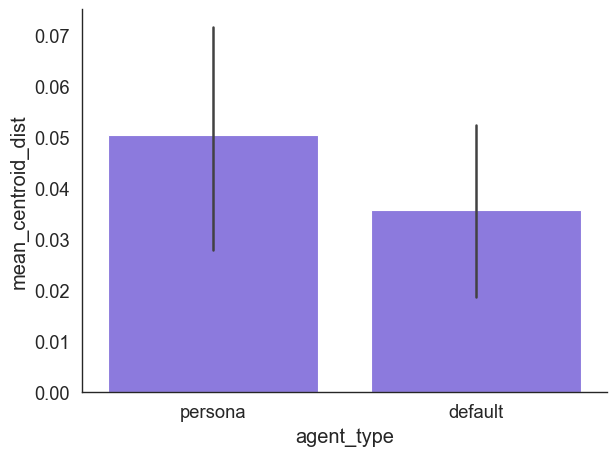

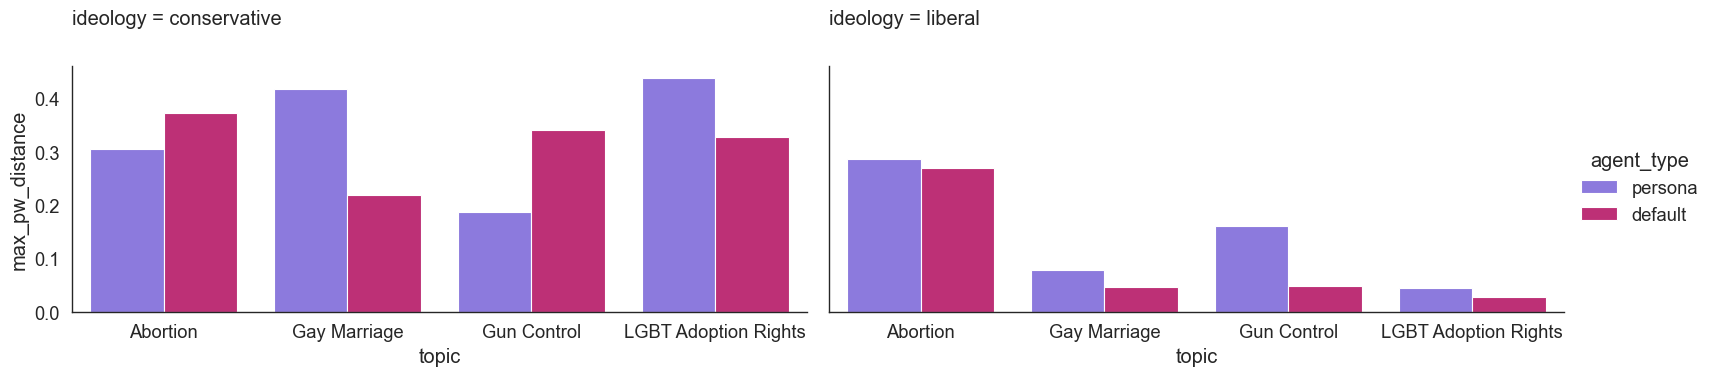

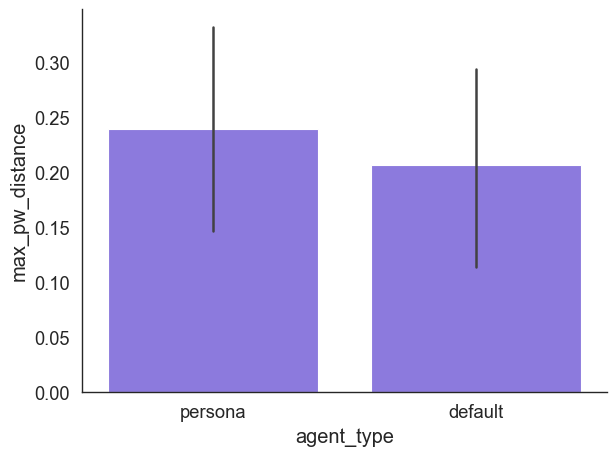

In [32]:
make_aesthetic(font_scale=1.5)
cols = div_df.columns.tolist()
bad_cols = ['topic', 'agent_type', 'ideology']
dvs = [col for col in cols if col not in bad_cols]

for dv in dvs:
    sns.catplot(x="topic", y=dv, 
                hue="agent_type", col="ideology", 
                data=div_df, kind="bar", height=4, aspect=2)
    plt.show()
    sns.barplot(x="agent_type", y=dv, data=div_df)
    plt.show()